In [ ]:
# 1) Imports and Drive mount (Colab)
import os
import math
import random
from glob import glob
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# If in Colab: mount drive
from google.colab import drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu


In [ ]:
# 2) Configuration - adjust these to your dataset/environment
# Point these to your Google Drive paths
DRIVE_BASE = "/content/drive/MyDrive/Microplastics iris isef"   # change if different
CSV_PATH = os.path.join(DRIVE_BASE, "labels_microplastic_2025-10-19-02-24-26.csv")  # example: /MyDrive/annotations.csv
DRIVE_IMG_DIR = os.path.join(DRIVE_BASE, "Train") # folder with training images
TEST_IMG_DIR = os.path.join(DRIVE_BASE, "Test")   # folder with test images (for inference)

# Image handling
IMG_SIZE = (512, 512)   # (width, height) - resize all images to this
SIGMA = 2.0             # gaussian sigma for each annotation in pixels (adjust if objects larger/smaller)
GAUSS_TRUNC = 4         # truncate gaussian at this many sigma

# Training
BATCH_SIZE = 4
EPOCHS = 30
LR = 1e-4
WEIGHT_COUNT_LOSS = 1.0  # weight for L1 count loss vs MSE density loss

# Misc
SEED = 42
os.makedirs("density_maps", exist_ok=True)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
# 3) Helper: create gaussian kernel and make density map for an image given list of annotations
from math import ceil

def gaussian_kernel_2d(sigma, truncate=4.0):
    # returns normalized kernel with sum = 1
    radius = int(truncate * sigma + 0.5)
    size = 2 * radius + 1
    ax = np.arange(-radius, radius+1)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel_sum = kernel.sum()
    if kernel_sum != 0:
        kernel = kernel / kernel_sum
    return kernel, radius

kernel2d, kernel_radius = gaussian_kernel_2d(SIGMA, GAUSS_TRUNC)
print("Kernel size:", kernel2d.shape, "radius:", kernel_radius)


Kernel size: (17, 17) radius: 8


In [ ]:
# 4) Load CSV and create GT density maps for the train images (saved to local 'density_maps/{image_name}.npy')
# CSV assumptions: columns named exactly: 'image', 'x', 'y'
# 'x' and 'y' are coordinates relative to the ORIGINAL image pixels (not normalized).
# If your CSV uses different names, change the column names below.

df = pd.read_csv(CSV_PATH)
print("CSV rows:", len(df))
print("CSV columns:", df.columns.tolist())
assert {'image','x','y'}.issubset(set(df.columns)), "CSV must contain 'image','x','y' columns"

# We will group annotations per image
grouped = df.groupby('image')

# function to generate density map for a given image path
def make_density_map_for_image(img_path, annots, out_size=IMG_SIZE):
    # img_path used to get original image size if coordinates are in original pixels.
    img = Image.open(img_path).convert('RGB')
    orig_w, orig_h = img.size
    out_w, out_h = out_size
    # if resizing, we need to scale coordinates
    scale_x = out_w / orig_w
    scale_y = out_h / orig_h

    density = np.zeros((out_h, out_w), dtype=np.float32)
    for x, y in annots:
        # scale coordinates
        sx = x * scale_x
        sy = y * scale_y
        # round center
        cx = int(round(sx))
        cy = int(round(sy))
        # place kernel centered at (cx, cy) with proper clipping
        r = kernel_radius
        k = kernel2d
        # kernel bounds in image
        x1 = cx - r
        x2 = cx + r
        y1 = cy - r
        y2 = cy + r

        # kernel coords
        kx1 = 0
        ky1 = 0
        kx2 = k.shape[1]-1
        ky2 = k.shape[0]-1

        # clip to image
        if x1 < 0:
            kx1 = -x1
            x1 = 0
        if y1 < 0:
            ky1 = -y1
            y1 = 0
        if x2 >= out_w:
            kx2 = k.shape[1]-1 - (x2 - (out_w-1))
            x2 = out_w-1
        if y2 >= out_h:
            ky2 = k.shape[0]-1 - (y2 - (out_h-1))
            y2 = out_h-1

        if (x1 <= x2) and (y1 <= y2):
            density[y1:y2+1, x1:x2+1] += k[ky1:ky2+1, kx1:kx2+1]
        # Kernel normalized to sum 1, so each annotated point adds about 1 to total sum
    return density

# Create and save all density maps (skips images without annotations by creating zero map if none)
train_image_paths = sorted(glob(os.path.join(DRIVE_IMG_DIR, "*")))
print(f"Found {len(train_image_paths)} images in train folder.")

# map image filename -> list of (x,y)
annots_map = {}
for img_name, group in grouped:
    annots_map[img_name] = list(zip(group['x'].astype(float).tolist(), group['y'].astype(float).tolist()))

# Iterate through train images and save density maps
for img_path in tqdm(train_image_paths, desc="Generating density maps"):
    img_name = os.path.basename(img_path)
    annots = annots_map.get(img_name, [])
    density = make_density_map_for_image(img_path, annots, out_size=IMG_SIZE)
    # small numeric safety: ensure non-neg
    density = np.clip(density, 0, None).astype(np.float32)
    # Save as npy with same name
    out_path = os.path.join("density_maps", img_name + ".npy")
    np.save(out_path, density)


CSV rows: 1400
CSV columns: ['image', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'x', 'y']
Found 77 images in train folder.


Generating density maps: 100%|██████████| 77/77 [00:01<00:00, 70.94it/s]


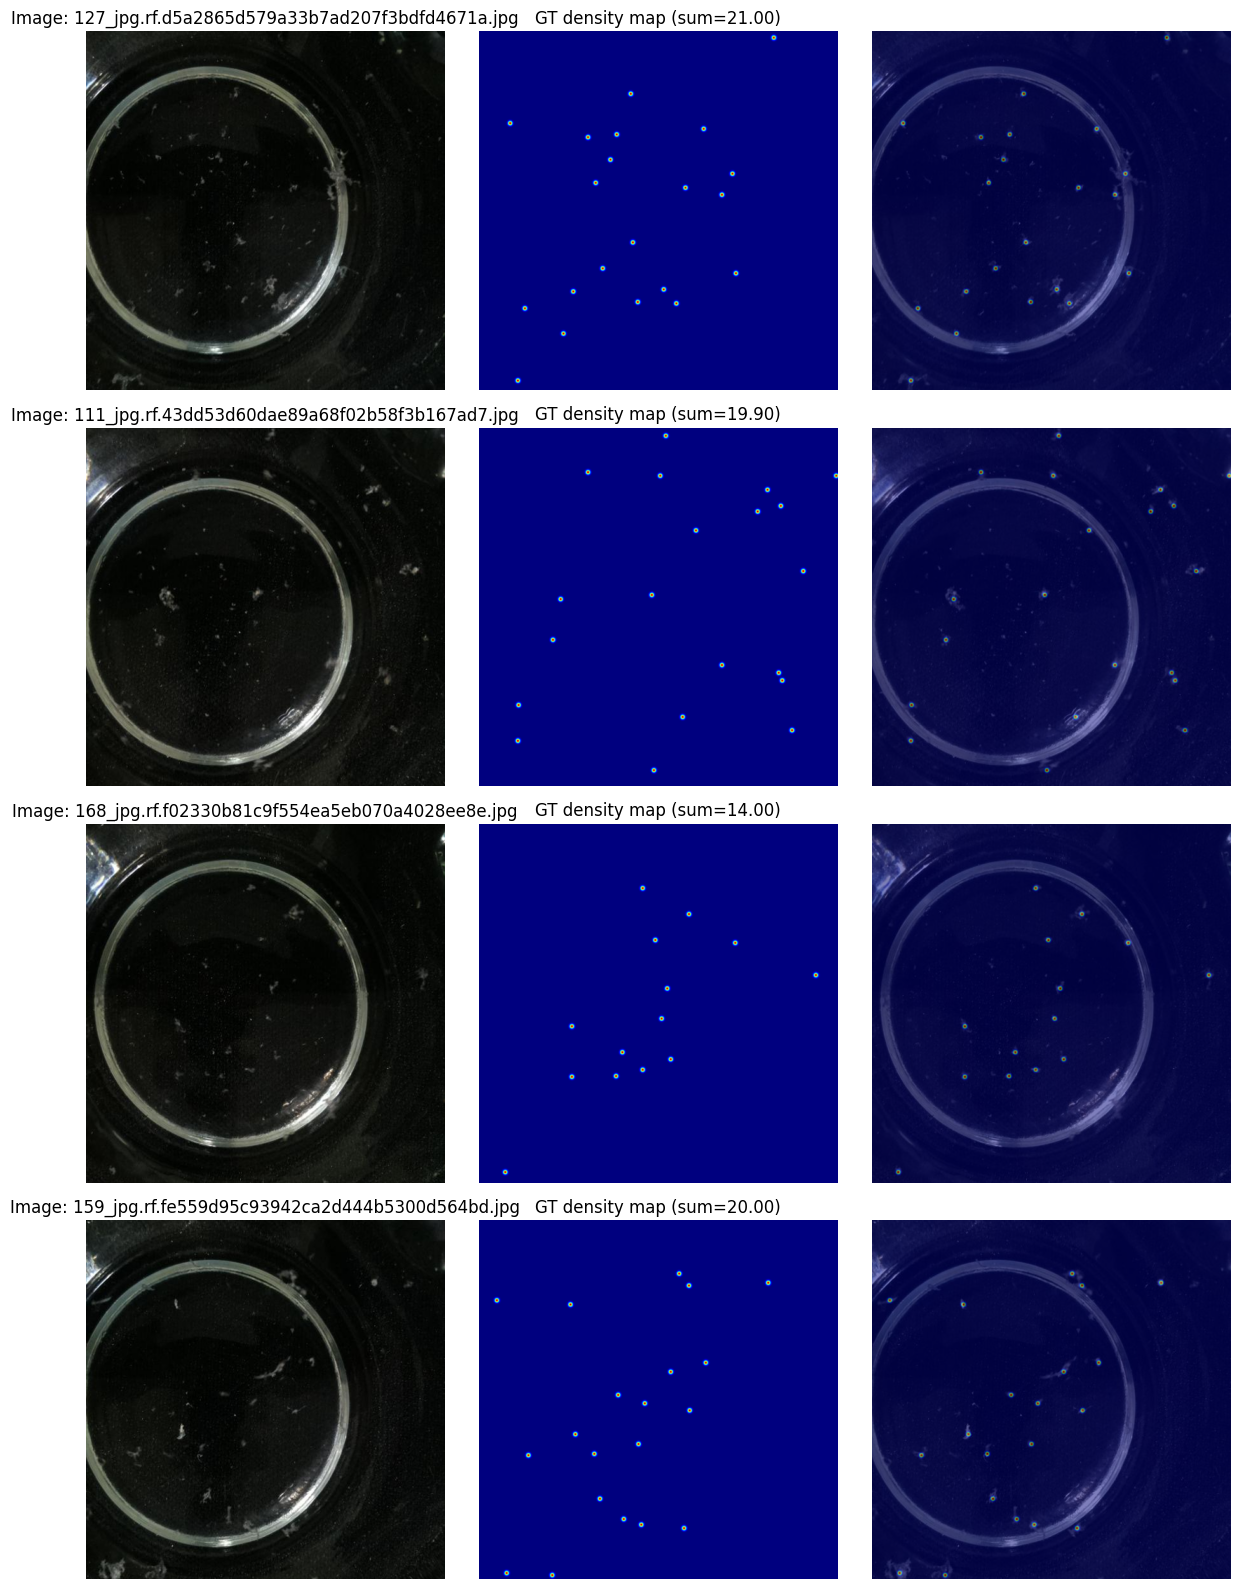

In [ ]:
# Quick sanity check: display some images with their density maps and the sum (counts)
def show_examples(n=6):
    fig, axs = plt.subplots(n, 3, figsize=(12, 4*n))
    sel = random.sample(train_image_paths, n)
    for i, p in enumerate(sel):
        img = Image.open(p).convert('RGB').resize(IMG_SIZE)
        img_arr = np.array(img)
        d = np.load(os.path.join("density_maps", os.path.basename(p) + ".npy"))
        total_count = d.sum()
        axs[i,0].imshow(img_arr)
        axs[i,0].set_title(f"Image: {os.path.basename(p)}")
        axs[i,0].axis('off')
        axs[i,1].imshow(d, cmap='jet')
        axs[i,1].set_title(f"GT density map (sum={total_count:.2f})")
        axs[i,1].axis('off')
        # overlay
        axs[i,2].imshow(img_arr)
        axs[i,2].imshow(d, cmap='jet', alpha=0.5)
        axs[i,2].axis('off')
    plt.tight_layout()

show_examples(4)


In [ ]:
# 5) Dataset and transforms
from torchvision import transforms

class MicroplasticsDataset(Dataset):
    def __init__(self, image_paths, density_dir="density_maps", img_size=IMG_SIZE, augment=False):
        self.image_paths = image_paths
        self.density_dir = density_dir
        self.img_size = img_size
        self.augment = augment
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),  # scales to [0,1], shape C,H,W
        ])
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        p = self.image_paths[idx]
        img = Image.open(p).convert('RGB').resize(self.img_size)
        img_t = self.to_tensor(img).float()
        # load density map
        dpath = os.path.join(self.density_dir, os.path.basename(p) + ".npy")
        density = np.load(dpath)
        # ensure shape H,W -> 1,H,W
        den_t = torch.from_numpy(density).unsqueeze(0).float()
        # optionally augment (simple flips)
        if self.augment:
            if random.random() > 0.5:
                img_t = torch.flip(img_t, dims=[2])  # horizontal
                den_t = torch.flip(den_t, dims=[2])
            if random.random() > 0.5:
                img_t = torch.flip(img_t, dims=[1])  # vertical
                den_t = torch.flip(den_t, dims=[1])
        return img_t, den_t

# split train/val
random.shuffle(train_image_paths)
val_split = int(0.85 * len(train_image_paths))
train_paths = train_image_paths[:val_split]
val_paths = train_image_paths[val_split:]
print("Train images:", len(train_paths), "Val images:", len(val_paths))

train_ds = MicroplasticsDataset(train_paths, augment=True)
val_ds = MicroplasticsDataset(val_paths, augment=False)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Train images: 65 Val images: 12


In [ ]:
# 6) UNet model (simple, reliable)
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_ch=3, out_ch=1, base_c=32):
        super().__init__()
        self.dconv_down1 = DoubleConv(in_ch, base_c)
        self.dconv_down2 = DoubleConv(base_c, base_c*2)
        self.dconv_down3 = DoubleConv(base_c*2, base_c*4)
        self.dconv_down4 = DoubleConv(base_c*4, base_c*8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(base_c*12, base_c*4)
        self.dconv_up2 = DoubleConv(base_c*6, base_c*2)
        self.dconv_up1 = DoubleConv(base_c*3, base_c)

        self.conv_last = nn.Conv2d(base_c, out_ch, kernel_size=1)
    def forward(self, x):
        # encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        x = self.dconv_down4(x)
        # decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        x = self.conv_last(x)
        # output density map: ensure non-negative (ReLU)
        x = F.relu(x)
        return x

model = UNet(in_ch=3, out_ch=1, base_c=32).to(device)
print(model)


UNet(
  (dconv_down1): DoubleConv(
    (net): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down2): DoubleConv(
    (net): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (dconv_down3): DoubleConv(
    (net): Sequential(
      (0): Conv2d(64, 128, 

In [ ]:
# 7) Loss, optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()

def combined_loss(pred, gt, weight_count=WEIGHT_COUNT_LOSS):
    # pred, gt: shape B,1,H,W
    mse = mse_loss(pred, gt)
    # count loss: L1 on sums
    pred_count = pred.view(pred.size(0), -1).sum(dim=1)
    gt_count = gt.view(gt.size(0), -1).sum(dim=1)
    cnt = l1_loss(pred_count, gt_count)
    return mse + weight_count * cnt, mse.item(), cnt.item(), pred_count.detach().cpu().numpy(), gt_count.detach().cpu().numpy()


Epoch 1/30 - train:   0%|          | 0/17 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/30 - train: 100%|██████████| 17/17 [10:54<00:00, 38.49s/it]


Epoch 1/30: train_loss=1831.4569, val_loss=18.5656, val_mean_abs_count_err=18.566
Saved best model.


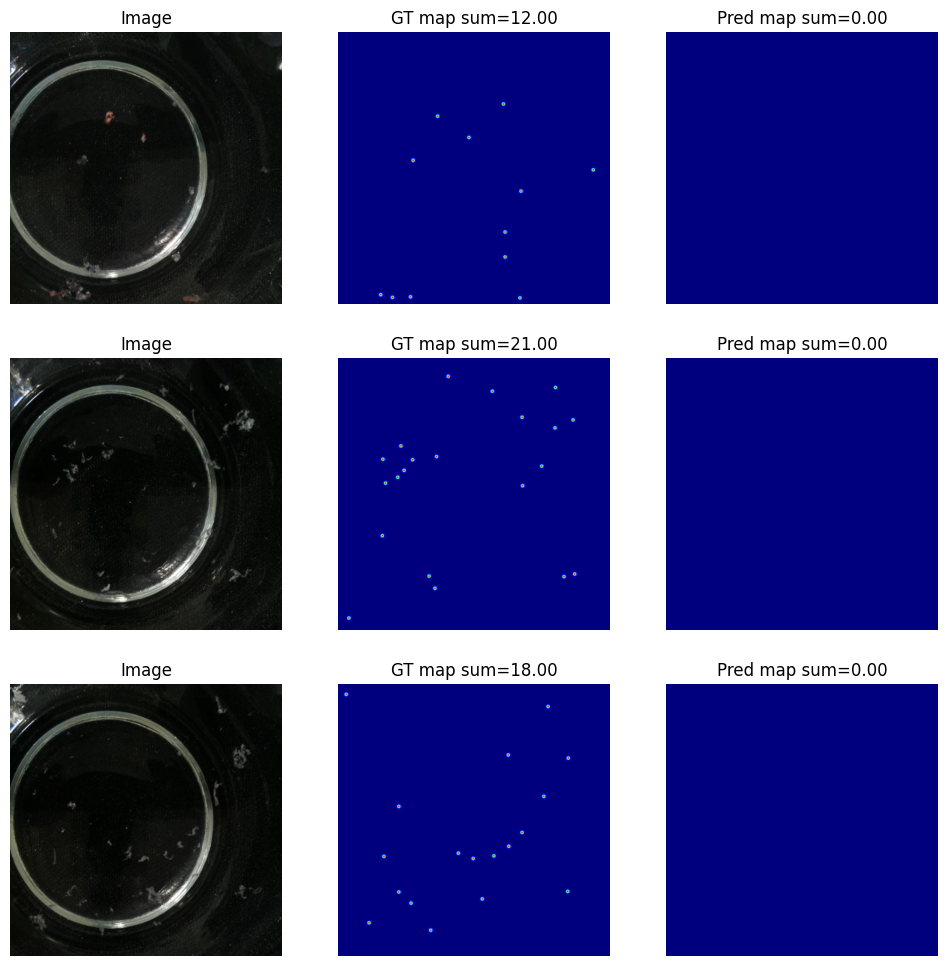

Epoch 2/30 - train: 100%|██████████| 17/17 [15:47<00:00, 55.74s/it]


Epoch 2/30: train_loss=8.2758, val_loss=18.2467, val_mean_abs_count_err=18.247
Saved best model.


Epoch 3/30 - train: 100%|██████████| 17/17 [15:53<00:00, 56.08s/it]


Epoch 3/30: train_loss=9.6775, val_loss=7.2024, val_mean_abs_count_err=7.202
Saved best model.


Epoch 4/30 - train: 100%|██████████| 17/17 [15:43<00:00, 55.51s/it]


Epoch 4/30: train_loss=8.4752, val_loss=5.9587, val_mean_abs_count_err=5.959
Saved best model.


Epoch 5/30 - train: 100%|██████████| 17/17 [15:36<00:00, 55.07s/it]


Epoch 5/30: train_loss=6.3551, val_loss=4.9774, val_mean_abs_count_err=4.977
Saved best model.


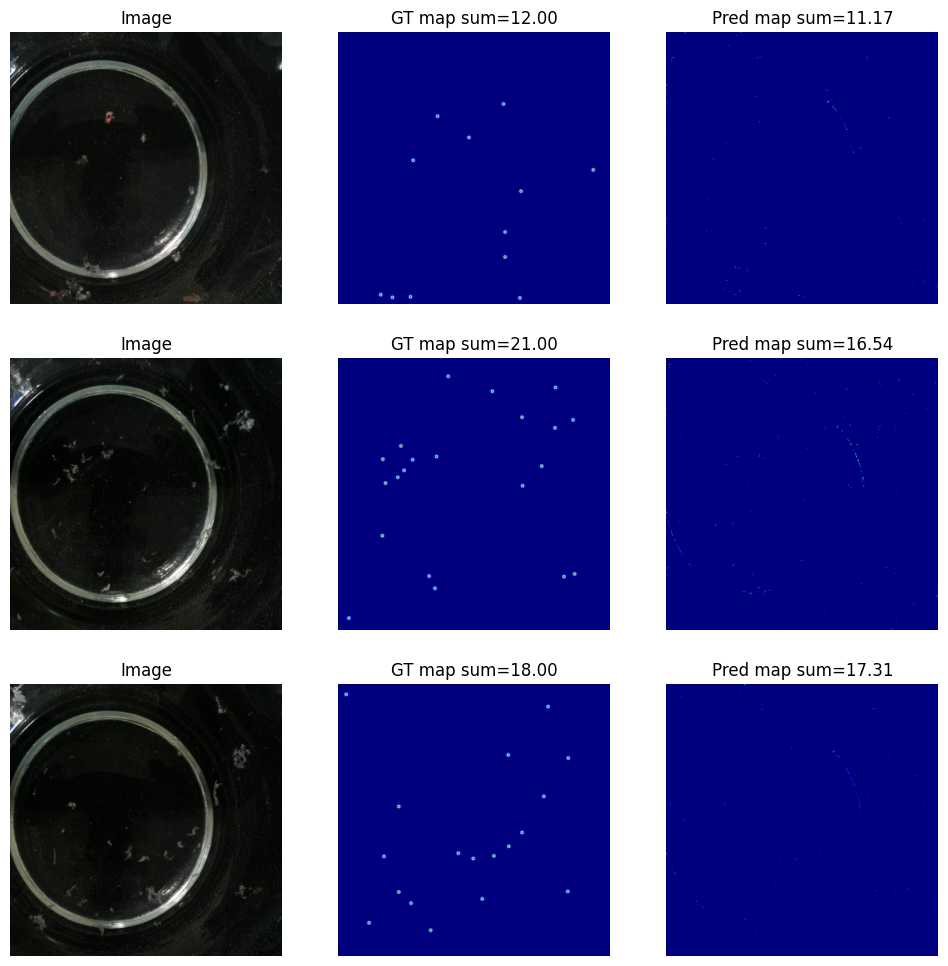

Epoch 6/30 - train: 100%|██████████| 17/17 [09:16<00:00, 32.71s/it]


Epoch 6/30: train_loss=6.5677, val_loss=5.4295, val_mean_abs_count_err=5.430


Epoch 7/30 - train: 100%|██████████| 17/17 [09:14<00:00, 32.64s/it]


Epoch 7/30: train_loss=5.6832, val_loss=5.7111, val_mean_abs_count_err=5.711


Epoch 8/30 - train: 100%|██████████| 17/17 [09:10<00:00, 32.39s/it]


Epoch 8/30: train_loss=5.8690, val_loss=6.1817, val_mean_abs_count_err=6.182


Epoch 9/30 - train: 100%|██████████| 17/17 [09:06<00:00, 32.15s/it]


Epoch 9/30: train_loss=5.0438, val_loss=5.5833, val_mean_abs_count_err=5.583


Epoch 10/30 - train: 100%|██████████| 17/17 [09:06<00:00, 32.16s/it]


Epoch 10/30: train_loss=4.8180, val_loss=4.8917, val_mean_abs_count_err=4.892
Saved best model.


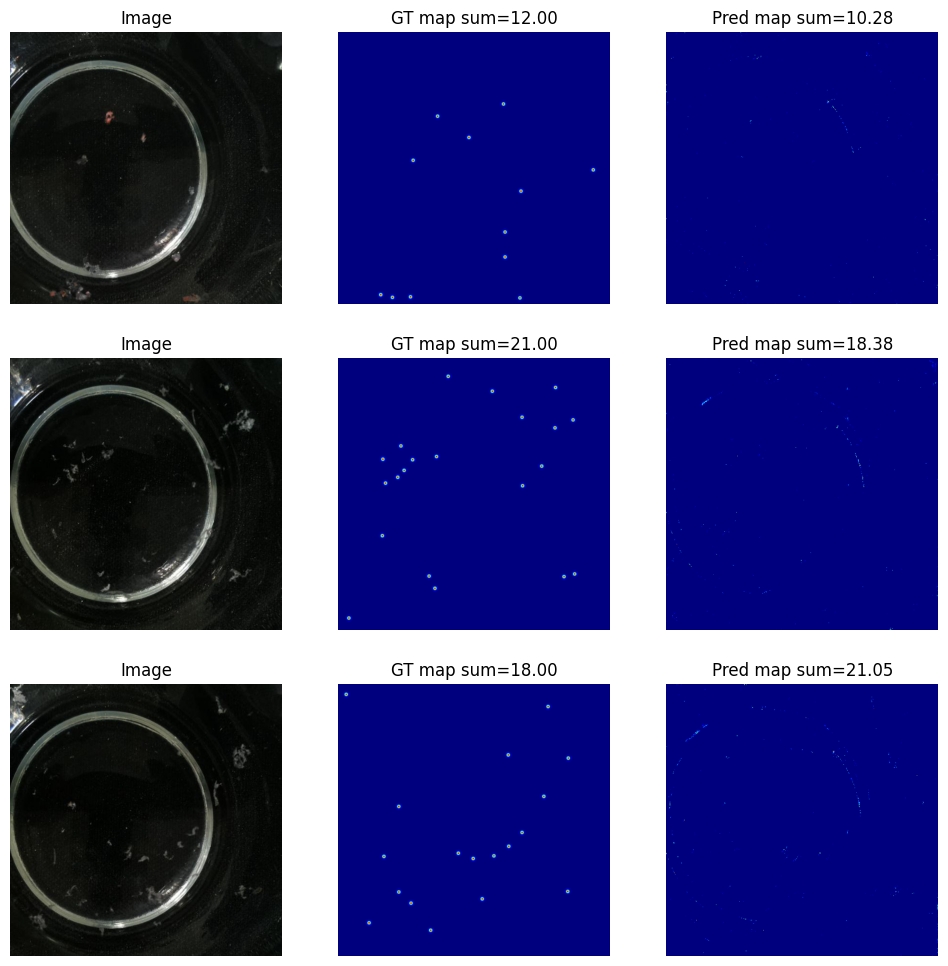

Epoch 11/30 - train: 100%|██████████| 17/17 [08:55<00:00, 31.47s/it]


Epoch 11/30: train_loss=5.3429, val_loss=5.3735, val_mean_abs_count_err=5.373


Epoch 12/30 - train: 100%|██████████| 17/17 [09:02<00:00, 31.92s/it]


Epoch 12/30: train_loss=5.7886, val_loss=5.3898, val_mean_abs_count_err=5.390


Epoch 13/30 - train:  29%|██▉       | 5/17 [02:44<06:31, 32.61s/it]

In [ ]:
# 8) Training loop with simple validation and visualization of predictions
from tqdm import trange

best_val = 1e9
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_mse = 0.0
    total_cntloss = 0.0
    n = 0
    for imgs, dens in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS} - train"):
        imgs = imgs.to(device)
        dens = dens.to(device)
        preds = model(imgs)
        loss, mse_val, cnt_val, _, _ = combined_loss(preds, dens)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_size = imgs.size(0)
        total_loss += loss.item() * batch_size
        total_mse += mse_val * batch_size
        total_cntloss += cnt_val * batch_size
        n += batch_size
    avg_loss = total_loss / n
    avg_mse = total_mse / n
    avg_cnt = total_cntloss / n

    # validation
    model.eval()
    val_loss = 0.0
    val_n = 0
    val_count_err = 0.0
    with torch.no_grad():
        for imgs, dens in val_dl:
            imgs = imgs.to(device)
            dens = dens.to(device)
            preds = model(imgs)
            loss, mse_val, cnt_val, pred_counts, gt_counts = combined_loss(preds, dens)
            val_loss += loss.item() * imgs.size(0)
            val_n += imgs.size(0)
            val_count_err += np.abs(pred_counts - gt_counts).sum()
    val_loss /= max(1, val_n)
    mean_count_err = val_count_err / max(1, val_n)

    print(f"Epoch {epoch+1}/{EPOCHS}: train_loss={avg_loss:.4f}, val_loss={val_loss:.4f}, val_mean_abs_count_err={mean_count_err:.3f}")

    # save best model
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_unet_density_count.pth")
        print("Saved best model.")

    # show a few val predictions every few epochs
    if (epoch+1) % max(1, EPOCHS//6) == 0 or epoch==0:
        # show first batch from val
        imgs, dens = next(iter(val_dl))
        imgs = imgs.to(device)
        dens = dens.to(device)
        with torch.no_grad():
            preds = model(imgs)
        preds_np = preds.detach().cpu().numpy()
        dens_np = dens.detach().cpu().numpy()
        imgs_np = imgs.detach().cpu().numpy()
        b = min(3, imgs_np.shape[0])
        plt.figure(figsize=(12,4*b))
        for i in range(b):
            plt.subplot(b,3,3*i+1)
            plt.imshow(np.transpose(imgs_np[i], (1,2,0)))
            plt.axis('off')
            plt.title("Image")
            plt.subplot(b,3,3*i+2)
            plt.imshow(dens_np[i,0], cmap='jet')
            plt.axis('off')
            plt.title(f"GT map sum={dens_np[i,0].sum():.2f}")
            plt.subplot(b,3,3*i+3)
            plt.imshow(preds_np[i,0], cmap='jet')
            plt.axis('off')
            plt.title(f"Pred map sum={preds_np[i,0].sum():.2f}")
        plt.show()


Found test images: 25


Predicting test images:   0%|          | 0/25 [00:00<?, ?it/s]

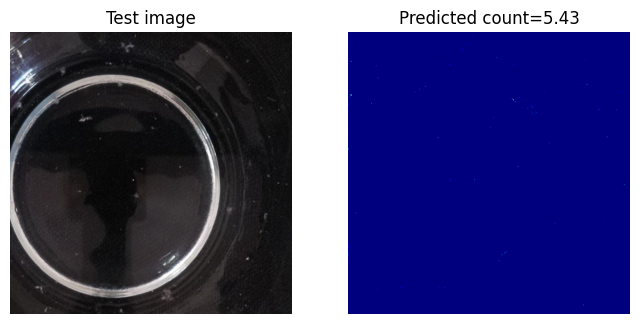

Predicting test images:   4%|▍         | 1/25 [00:06<02:24,  6.04s/it]

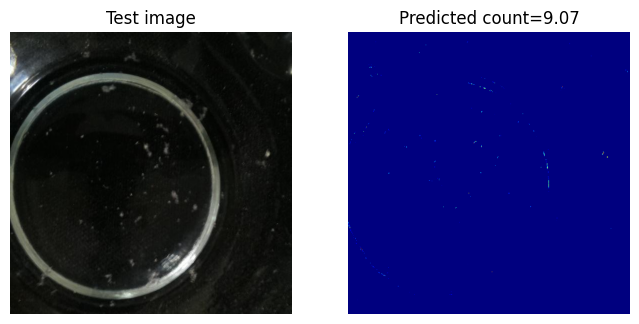

Predicting test images:   8%|▊         | 2/25 [00:10<01:55,  5.01s/it]

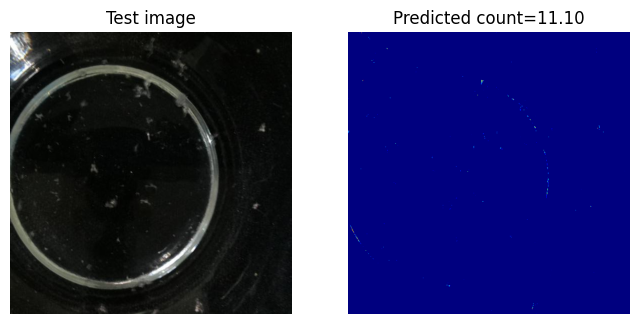

Predicting test images:  12%|█▏        | 3/25 [00:15<01:49,  4.98s/it]

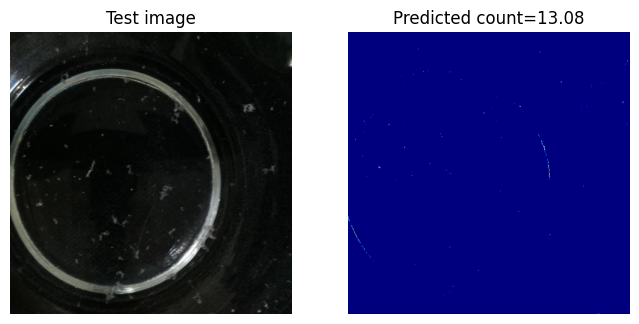

Predicting test images:  16%|█▌        | 4/25 [00:21<01:54,  5.46s/it]

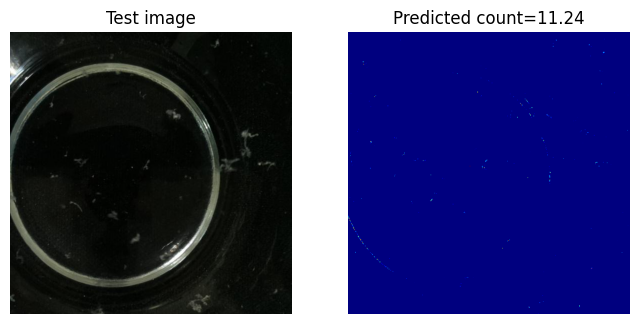

Predicting test images:  20%|██        | 5/25 [00:25<01:39,  4.98s/it]

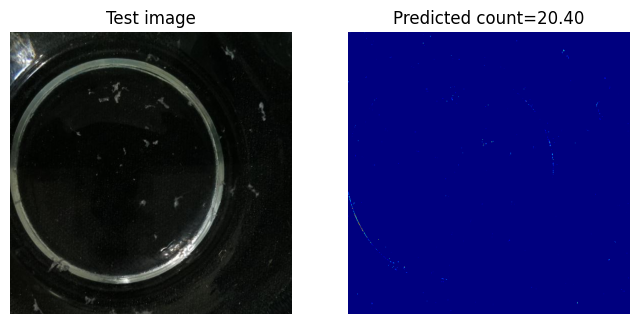

Predicting test images:  24%|██▍       | 6/25 [00:29<01:30,  4.75s/it]

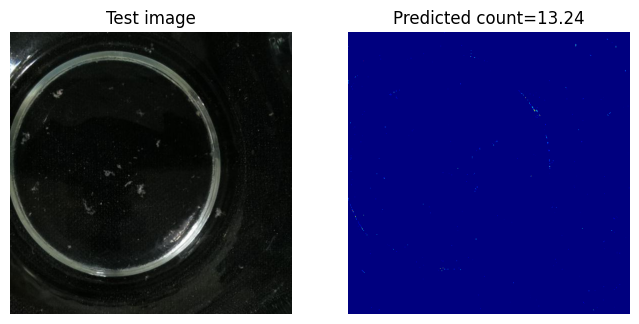

Predicting test images:  28%|██▊       | 7/25 [00:36<01:34,  5.24s/it]

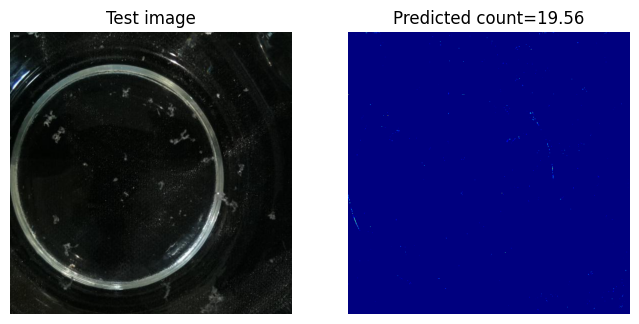

Predicting test images:  32%|███▏      | 8/25 [00:40<01:23,  4.94s/it]

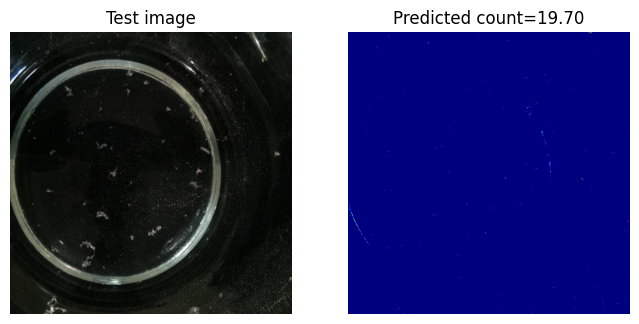

Predicting test images:  36%|███▌      | 9/25 [00:44<01:15,  4.74s/it]

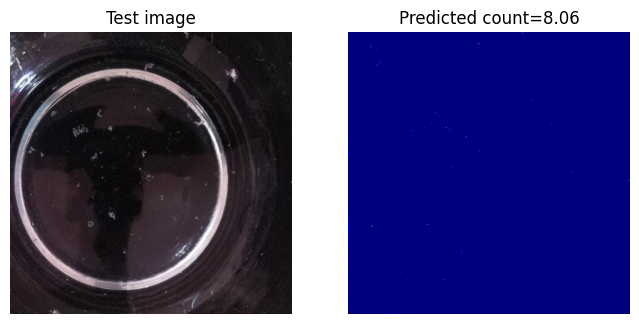

Predicting test images:  40%|████      | 10/25 [00:50<01:17,  5.14s/it]

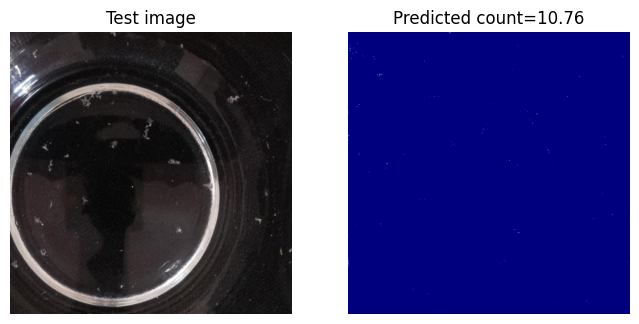

Predicting test images:  44%|████▍     | 11/25 [00:56<01:12,  5.18s/it]

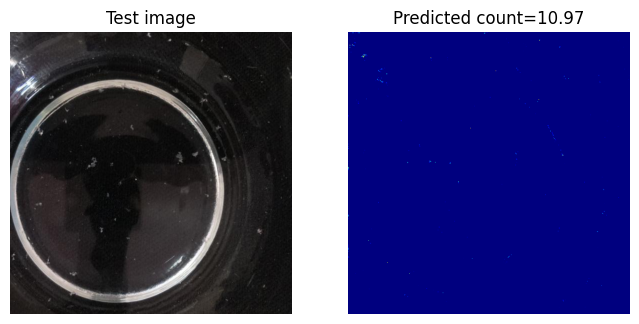

Predicting test images:  48%|████▊     | 12/25 [01:00<01:06,  5.11s/it]

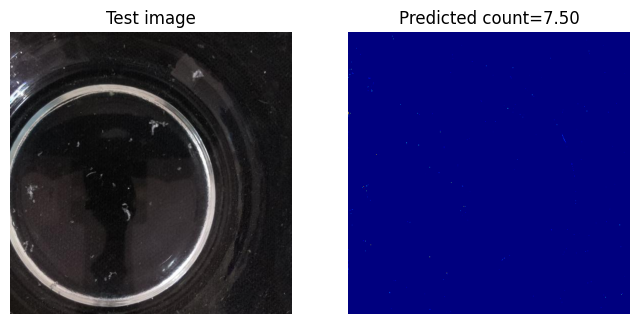

Predicting test images:  52%|█████▏    | 13/25 [01:07<01:04,  5.41s/it]

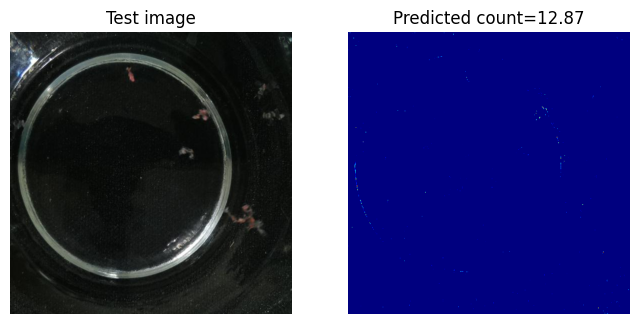

Predicting test images:  56%|█████▌    | 14/25 [01:11<00:56,  5.15s/it]

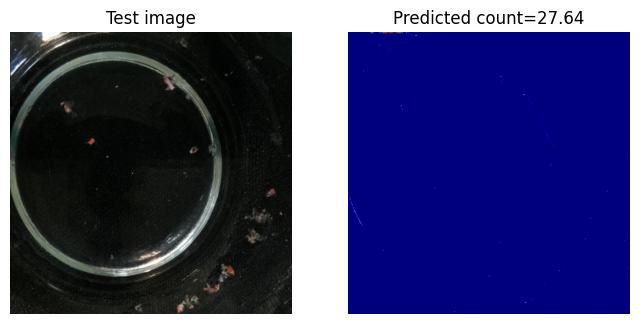

Predicting test images:  60%|██████    | 15/25 [01:17<00:53,  5.34s/it]

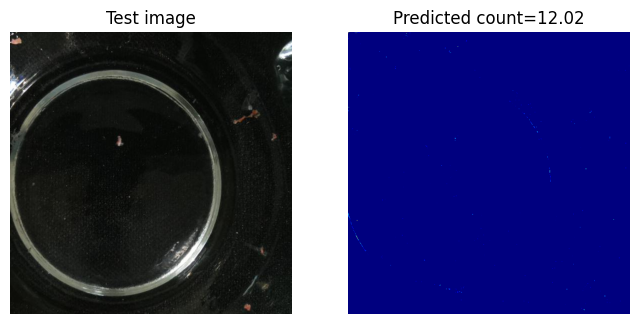

Predicting test images:  64%|██████▍   | 16/25 [01:23<00:49,  5.55s/it]

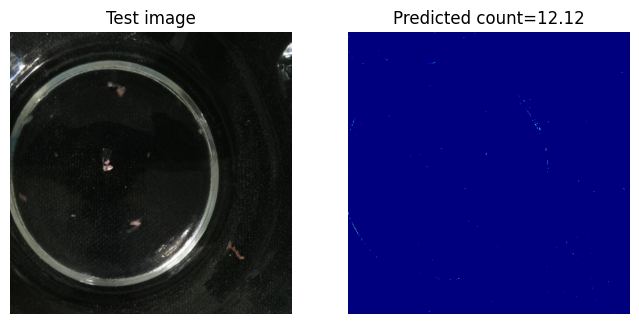

Predicting test images:  68%|██████▊   | 17/25 [01:27<00:41,  5.15s/it]

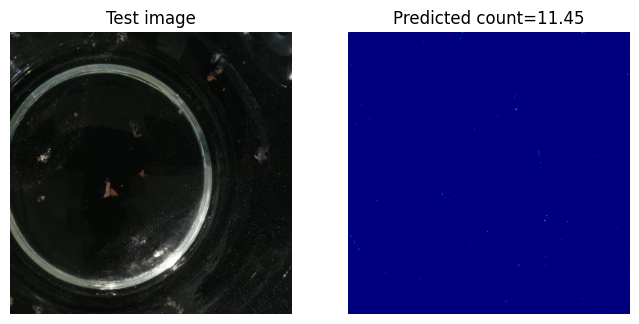

Predicting test images:  72%|███████▏  | 18/25 [01:32<00:34,  4.93s/it]

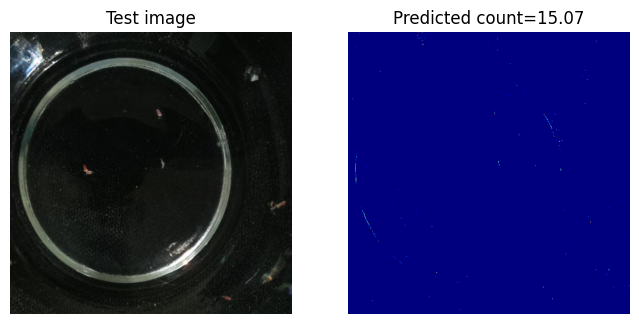

Predicting test images:  76%|███████▌  | 19/25 [01:38<00:31,  5.24s/it]

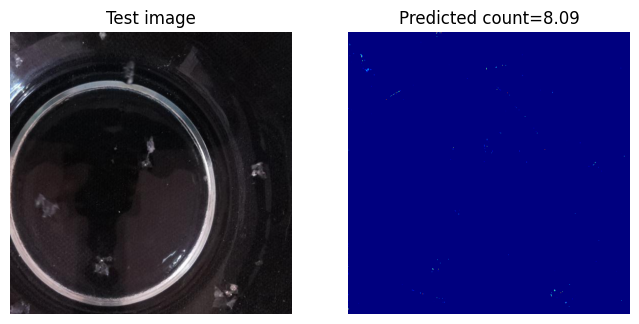

Predicting test images:  80%|████████  | 20/25 [01:42<00:25,  5.06s/it]

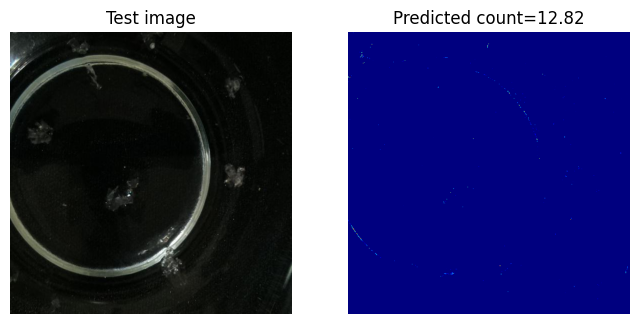

Predicting test images:  84%|████████▍ | 21/25 [01:46<00:19,  4.79s/it]

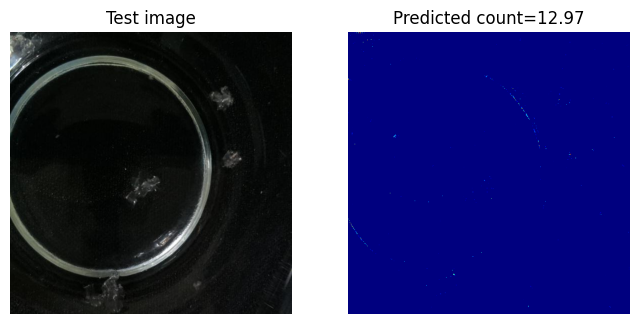

Predicting test images:  88%|████████▊ | 22/25 [01:52<00:14,  4.94s/it]

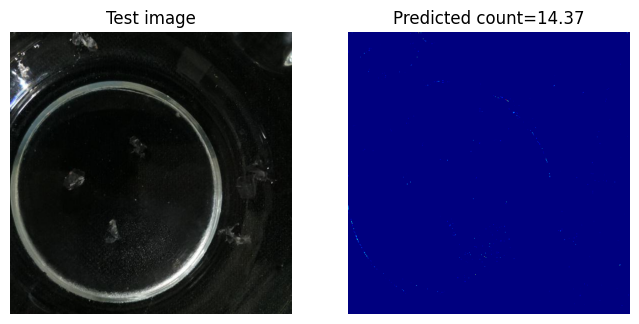

Predicting test images:  92%|█████████▏| 23/25 [01:57<00:09,  4.95s/it]

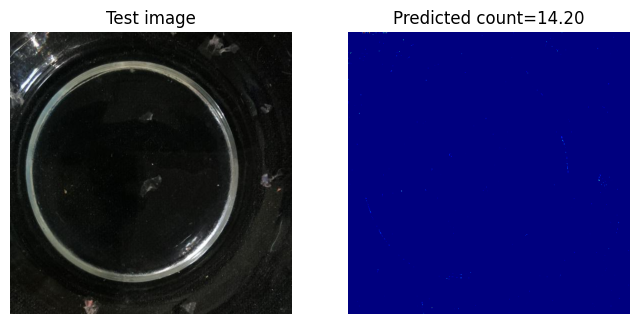

Predicting test images:  96%|█████████▌| 24/25 [02:01<00:04,  4.80s/it]

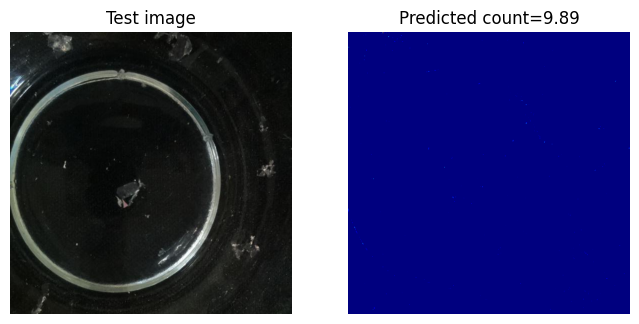

Predicting test images: 100%|██████████| 25/25 [02:06<00:00,  5.07s/it]

                                                image  pred_count
0     100_jpg.rf.f1b9d16649ab385e3691fa54301a3b61.jpg    5.433897
1     115_jpg.rf.b67b6f9a57244ad787dd942e85efcc4c.jpg    9.074362
2     123_jpg.rf.ad9bf1104c3cf812645aed431a1a027a.jpg   11.098494
3     134_jpg.rf.bfc2b2ce193188b9213229e9ff725045.jpg   13.084528
4     143_jpg.rf.4bf2d593b2dcffe4a19da0d590ed30cb.jpg   11.240829
5     155_jpg.rf.093f66fb1b5c68857d3fb733ea6c28e0.jpg   20.395866
6     165_jpg.rf.5e80636a4986a65a5e690d9eab5b306a.jpg   13.236287
7     187_jpg.rf.7f833781344024db5ea914b4f28b2501.jpg   19.564663
8     190_jpg.rf.bbffa7ff0e9df3f2603745032d9e56cb.jpg   19.698812
9      29_jpg.rf.2d7a802a59f28f44700485e2f7ad912b.jpg    8.060732
10     49_jpg.rf.3ce02da66fc92f94786590c28eab61b0.jpg   10.757753
11     56_jpg.rf.46f86d32fd5434fd10da2d9c13360539.jpg   10.971150
12  b--194-_jpg.rf.34be8174d4d93ba21f988246a70ac27...    7.503316
13  c--116-_jpg.rf.802c76ffa6e8dfdad98bedf841f2ae6...   12.867866
14  c--13-

In [ ]:
# 9) Inference on test folder: predict density maps and counts for unknown images
# Ensure you have saved model weights earlier: "best_unet_density_count.pth"
model.load_state_dict(torch.load("best_unet_density_count.pth", map_location=device))
model.eval()

test_image_paths = sorted(glob(os.path.join(TEST_IMG_DIR, "*")))
print("Found test images:", len(test_image_paths))

results = []
for p in tqdm(test_image_paths, desc="Predicting test images"):
    img = Image.open(p).convert('RGB').resize(IMG_SIZE)
    img_t = transforms.ToTensor()(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred = model(img_t)
    pred_np = pred.squeeze(0).squeeze(0).cpu().numpy()
    pred_count = pred_np.sum()
    results.append((os.path.basename(p), pred_count))
    # save predicted density map as npy or image if you like
    np.save(os.path.join("pred_density_"+os.path.basename(p)+".npy"), pred_np)
    # optionally save a visualization
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Test image")
    plt.subplot(1,2,2)
    plt.imshow(pred_np, cmap='jet')
    plt.title(f"Predicted count={pred_count:.2f}")
    plt.axis('off')
    plt.show()

# tabulate
res_df = pd.DataFrame(results, columns=['image', 'pred_count'])
print(res_df.head(20))
res_df.to_csv("test_predictions.csv", index=False)
print("Saved test_predictions.csv")
